In [1]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error

from models import *
from autoencoder import *
from utils import *
from data import *

In [2]:
import os, pickle
import time
import random
import warnings
warnings.filterwarnings("ignore")

In [3]:
ts_configs = [
    ("Births",       Births,       31),
    ("Temperatures", Temperatures, 31),
]
autoencoder_embedding_flags = [False, True]
metrics_list = ["euclidean", "manhattan", "cosine"]
latent_dim = 8

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda



Training AE on Births (window_size=31)
  Epoch 1/30 — loss: 0.564178
  Epoch 2/30 — loss: 0.222991
  Epoch 3/30 — loss: 0.140435
  Epoch 4/30 — loss: 0.104529
  Epoch 5/30 — loss: 0.093668
  Epoch 6/30 — loss: 0.087466
  Epoch 7/30 — loss: 0.082399
  Epoch 8/30 — loss: 0.078462
  Epoch 9/30 — loss: 0.075410
  Epoch 10/30 — loss: 0.072888
  Epoch 11/30 — loss: 0.070696
  Epoch 12/30 — loss: 0.069237
  Epoch 13/30 — loss: 0.067547
  Epoch 14/30 — loss: 0.066463
  Epoch 15/30 — loss: 0.065129
  Epoch 16/30 — loss: 0.064993
  Epoch 17/30 — loss: 0.063464
  Epoch 18/30 — loss: 0.062760
  Epoch 19/30 — loss: 0.062028
  Epoch 20/30 — loss: 0.061388
  Epoch 21/30 — loss: 0.060640
  Epoch 22/30 — loss: 0.060025
  Epoch 23/30 — loss: 0.059998
  Epoch 24/30 — loss: 0.058881
  Epoch 25/30 — loss: 0.058720
  Epoch 26/30 — loss: 0.058473
  Epoch 27/30 — loss: 0.057815
  Epoch 28/30 — loss: 0.057684
  Epoch 29/30 — loss: 0.057001
  Epoch 30/30 — loss: 0.056307
Saved AE: autoencoders\ae_Births.pth


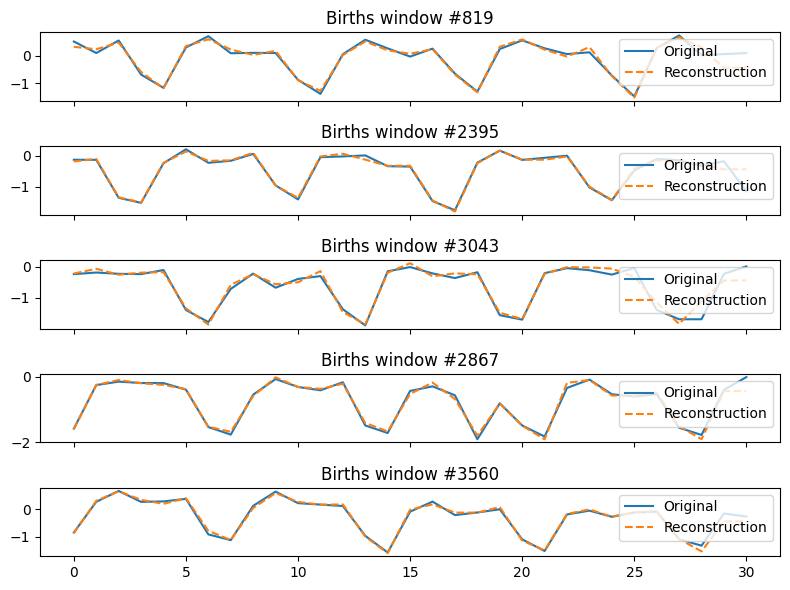


Training AE on Temperatures (window_size=31)
  Epoch 1/30 — loss: 0.992528
  Epoch 2/30 — loss: 0.443486
  Epoch 3/30 — loss: 0.330194
  Epoch 4/30 — loss: 0.287638
  Epoch 5/30 — loss: 0.251556
  Epoch 6/30 — loss: 0.237829
  Epoch 7/30 — loss: 0.226301
  Epoch 8/30 — loss: 0.212117
  Epoch 9/30 — loss: 0.212225
  Epoch 10/30 — loss: 0.199780
  Epoch 11/30 — loss: 0.201323
  Epoch 12/30 — loss: 0.205554
  Epoch 13/30 — loss: 0.197233
  Epoch 14/30 — loss: 0.194168
  Epoch 15/30 — loss: 0.199932
  Epoch 16/30 — loss: 0.190071
  Epoch 17/30 — loss: 0.188166
  Epoch 18/30 — loss: 0.186628
  Epoch 19/30 — loss: 0.192966
  Epoch 20/30 — loss: 0.191492
  Epoch 21/30 — loss: 0.182216
  Epoch 22/30 — loss: 0.182796
  Epoch 23/30 — loss: 0.181067
  Epoch 24/30 — loss: 0.180696
  Epoch 25/30 — loss: 0.178959
  Epoch 26/30 — loss: 0.177796
  Epoch 27/30 — loss: 0.170505
  Epoch 28/30 — loss: 0.166774
  Epoch 29/30 — loss: 0.164492
  Epoch 30/30 — loss: 0.155951
Saved AE: autoencoders\ae_Tempera

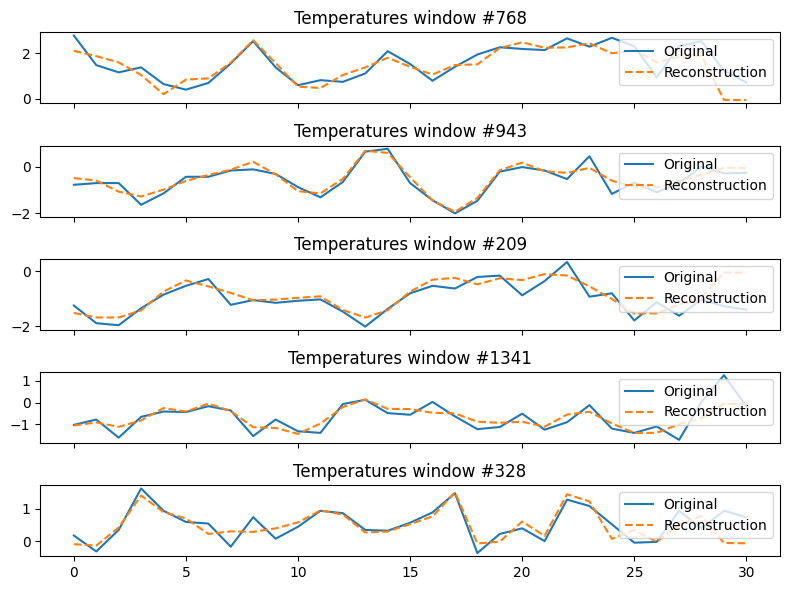

In [4]:
epochs = 30
lr     = 1e-3

for ds_name, DS, window_size in ts_configs:
    print(f"\nTraining AE on {ds_name} (window_size={window_size})")
    ts = DS(path=None, normalize=True)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)
    
    
    # model + optimizer + loss
    ae        = ConvAutoencoder1D(window_size, latent_dim).to(device)
    optimizer = torch.optim.Adam(ae.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    # wrap as DataLoader of shape (batch, 1, window_size)
    ds_loader = DataLoader(
        TensorDataset(torch.tensor(X_train, dtype=torch.float).unsqueeze(1)),
        batch_size=64, shuffle=True
    )
    
    # training loop
    for epoch in range(1, epochs + 1):
        losses = []
        ae.train()
        for (batch_x,) in ds_loader:
            batch_x = batch_x.to(device)
            recon   = ae(batch_x)
            loss    = criterion(recon, batch_x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        print(f"  Epoch {epoch}/{epochs} — loss: {np.mean(losses):.6f}")
    
    # save per‐dataset autoencoder
    ckpt_path = os.path.join("autoencoders", f"ae_{ds_name}.pth")
    torch.save(ae.state_dict(), ckpt_path)
    print(f"Saved AE: {ckpt_path}")

    # 6. Visualize reconstructions in eval mode
    ae.eval()
    sample_idxs = random.sample(range(len(X_train)), 5)
    fig, axes = plt.subplots(5, 1, figsize=(8, 6), sharex=True)
    for ax, idx in zip(axes, sample_idxs):
        orig = X_train[idx]
        with torch.no_grad():
            inp = torch.tensor(orig, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)
            recon = ae(inp).cpu().squeeze().numpy()
        ax.plot(orig, label="Original")
        ax.plot(recon, linestyle="--", label="Reconstruction")
        ax.set_title(f"{ds_name} window #{idx}")
        ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

In [ ]:
for ds_name, DS, window_size in ts_configs:
    print(f"\n→ Dataset: {ds_name} (window_size={window_size})")
    ts = DS(path=None, normalize=True)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)

    forecasters = {
    "ARIMA": ARIMAForecaster(),
    "ExpSmoothing": ExpSmoothingForecaster(),
    "LinearRegression": LinearRegressionForecaster(),
    "RandomForest": RandomForestForecaster(),
    "SVR": SVRForecaster(),
    "GradientBoosting": GradientBoostingForecaster(),
    "DT": DecisionTreeForecaster(),
    "MLP": MLPForecaster(),
    "LSTM": LSTMForecaster(window_size=window_size),
    "BiLSTM": BiLSTMForecaster(window_size=window_size),
    "CNNLSTM": CNNLSTMForecaster(window_size=window_size),
    }

    for name, model in forecasters.items():
        print(f"    → Training {name}…", end=" ")
        model.fit(X_train, y_train)

        # save the entire model object as a .pkl
        save_path = os.path.join("models", f"{ds_name}_{name}.pkl")
        with open(save_path, "wb") as f:
            pickle.dump(model, f)
        print(f"DONE: {save_path}")


→ Dataset: Births (window_size=31)
    → Training ARIMA… DONE: models\Births_ARIMA.pkl
    → Training ExpSmoothing… DONE: models\Births_ExpSmoothing.pkl
    → Training LinearRegression… DONE: models\Births_LinearRegression.pkl
    → Training RandomForest… DONE: models\Births_RandomForest.pkl
    → Training SVR… DONE: models\Births_SVR.pkl
    → Training GradientBoosting… DONE: models\Births_GradientBoosting.pkl
    → Training MLP… DONE: models\Births_MLP.pkl
    → Training LSTM… 1/30 0.47125 | 15/30 0.08583 | 30/30 0.05632 | DONE: models\Births_LSTM.pkl
    → Training BiLSTM… 1/30 0.42339 | 15/30 0.06526 | 30/30 0.05883 | DONE: models\Births_BiLSTM.pkl
    → Training CNNLSTM… 1/30 0.31368 | 15/30 0.06711 | 30/30 0.05366 | DONE: models\Births_CNNLSTM.pkl

→ Dataset: Temperatures (window_size=31)
    → Training ARIMA… DONE: models\Temperatures_ARIMA.pkl
    → Training ExpSmoothing… DONE: models\Temperatures_ExpSmoothing.pkl
    → Training LinearRegression… DONE: models\Temperatures_Line

In [6]:
MODELS_DIR = "models"
AE_DIR = "autoencoders"

loaded = {}
for ds_name, DS, window_size in ts_configs:
    print(f"\n→ Loading models for {ds_name} (window_size={window_size})")
    
    # 1) Load Autoencoder
    ae = ConvAutoencoder1D(window_size, latent_dim).eval().to(device)
    ae_ckpt = os.path.join(AE_DIR, f"ae_{ds_name}.pth")
    ae.load_state_dict(torch.load(ae_ckpt, map_location=device))
    print(f"     AE loaded from {ae_ckpt}")
    
    # 2) Load Forecasters
    forecasters = {}
    for name in [
        "ARIMA","ExpSmoothing","LinearRegression","RandomForest",
        "SVR","GradientBoosting","DT","MLP","LSTM","BiLSTM","CNNLSTM"
    ]:
        pkl_path = os.path.join(MODELS_DIR, f"{ds_name}_{name}.pkl")
        with open(pkl_path, "rb") as f:
            forecasters[name] = pickle.load(f)
        print(f"     {name} loaded from {pkl_path}")
    
    # store for later
    loaded[ds_name] = {
        "ae": ae,
        "forecasters": forecasters
    }


→ Loading models for Births (window_size=31)
     AE loaded from autoencoders\ae_Births.pth
     ARIMA loaded from models\Births_ARIMA.pkl
     ExpSmoothing loaded from models\Births_ExpSmoothing.pkl
     LinearRegression loaded from models\Births_LinearRegression.pkl
     RandomForest loaded from models\Births_RandomForest.pkl
     SVR loaded from models\Births_SVR.pkl
     GradientBoosting loaded from models\Births_GradientBoosting.pkl
     DT loaded from models\Births_DT.pkl
     MLP loaded from models\Births_MLP.pkl
     LSTM loaded from models\Births_LSTM.pkl
     BiLSTM loaded from models\Births_BiLSTM.pkl
     CNNLSTM loaded from models\Births_CNNLSTM.pkl

→ Loading models for Temperatures (window_size=31)
     AE loaded from autoencoders\ae_Temperatures.pth
     ARIMA loaded from models\Temperatures_ARIMA.pkl
     ExpSmoothing loaded from models\Temperatures_ExpSmoothing.pkl
     LinearRegression loaded from models\Temperatures_LinearRegression.pkl
     RandomForest loaded fro

In [7]:
for ds_name, DS, window_size in ts_configs:
    print(f"\n=== Validation RoC for {ds_name} (window_size={window_size}) ===")
    
    # Load data
    ts = DS(path=None, normalize=True)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)

    # Load models
    ae          = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]

    # Clear both RoCs
    for model in forecasters.values():
        model.rocs["raw"].clear()
        model.rocs["latent"].clear()

    # Iterate once over validation windows
    for idx, window in enumerate(X_val):
        # a) Pick winner based on raw input
        errors = {}
        for name, model in forecasters.items():
            y_pred = model.predict(window)
            errors[name] = mean_squared_error([y_val[idx]], [y_pred])
        winner = min(errors, key=errors.get)

        # b) Store both raw and latent versions
        raw_vec = window
        with torch.no_grad():
            latent_vec = ae.encode(window).cpu()

        forecasters[winner].rocs["raw"].append(raw_vec)
        forecasters[winner].rocs["latent"].append(latent_vec)

    # Report results
    print("RoC sizes")
    for name, model in forecasters.items():
        count = len(model.rocs["raw"])
        print(f"  {name:<18} {count:4d} entries")



=== Validation RoC for Births (window_size=31) ===
RoC sizes
  ARIMA               102 entries
  ExpSmoothing         55 entries
  LinearRegression    203 entries
  RandomForest        180 entries
  SVR                 184 entries
  GradientBoosting    213 entries
  DT                  170 entries
  MLP                 200 entries
  LSTM                147 entries
  BiLSTM              126 entries
  CNNLSTM             215 entries

=== Validation RoC for Temperatures (window_size=31) ===
RoC sizes
  ARIMA                82 entries
  ExpSmoothing         61 entries
  LinearRegression     49 entries
  RandomForest         91 entries
  SVR                  76 entries
  GradientBoosting     45 entries
  DT                  137 entries
  MLP                 111 entries
  LSTM                 71 entries
  BiLSTM               65 entries
  CNNLSTM              93 entries


In [8]:
# Lists to collect detailed disagreements and high-level summaries
disagreements = []
summary_list = []

print(f"Bottleneck size: {latent_dim}")
for ds_name, DS, window_size in ts_configs:
    print(f"\n=== Dataset: {ds_name} ===")
    # rebuild all splits
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)
    y_true = y_test if isinstance(y_test, np.ndarray) else y_test.cpu().numpy()

    ae = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]
    n_windows = len(X_test)

    for metric in metrics_list:
        # ---- RAW inference ----
        t0 = time.perf_counter()
        raw_preds, raw_models = [], []
        for w in X_test:
            q = w  # raw query
            # nearest‐RoC lookup in raw space
            best_name, best_dist = None, float("inf")
            for name, model in forecasters.items():
                for entry in model.rocs["raw"]:
                    d = compute_distance(q, entry, metric=metric)
                    if d < best_dist:
                        best_dist, best_name = d, name
            raw_models.append(best_name)
            raw_preds.append(forecasters[best_name].predict(w))
        time_raw = time.perf_counter() - t0
        mse_raw  = mean_squared_error(y_true, raw_preds)

        # ---- LATENT inference ----
        t1 = time.perf_counter()
        lat_preds, lat_models = [], []
        for w in X_test:
            with torch.no_grad():
                q = ae.encode(w).cpu()  # latent query (torch.Tensor)
            best_name, best_dist = None, float("inf")
            for name, model in forecasters.items():
                for entry in model.rocs["latent"]:
                    # entry is already a tensor
                    d = compute_distance(q, entry, metric=metric)
                    if d < best_dist:
                        best_dist, best_name = d, name
            lat_models.append(best_name)
            lat_preds.append(forecasters[best_name].predict(w))
        time_lat = time.perf_counter() - t1
        mse_lat  = mean_squared_error(y_true, lat_preds)

        # ---- Record disagreements ----
        n_dis = 0
        for idx, (rm, lm, yt, pr, pl) in enumerate(zip(raw_models, lat_models, y_true, raw_preds, lat_preds)):
            if rm != lm:
                n_dis += 1
                disagreements.append({
                    "dataset":      ds_name,
                    "metric":       metric,
                    "win_idx":      idx,
                    "raw_model":    rm,
                    "lat_model":    lm,
                    "y_true":       yt,
                    "y_pred_raw":   pr,
                    "y_pred_lat":   pl,
                })
        rate = n_dis / n_windows

        # ---- Append summary ----
        summary_list.append({
            "dataset":          ds_name,
            "metric":           metric,
            "test_mse_raw":     mse_raw,
            "test_mse_lat":     mse_lat,
            "time_raw":         time_raw,
            "time_lat":         time_lat,
            "n_disagreements":  n_dis,
            "disagreement_rate":rate,
        })

        # ---- Print concise line ----
        print(
            f"[{metric:^9}] "
            f"raw MSE={mse_raw:.4f}@{time_raw:.2f}s | "
            f"lat MSE={mse_lat:.4f}@{time_lat:.2f}s | "
            f"dis={n_dis}/{n_windows} ({rate:.2%})"
        )

df_dis      = pd.DataFrame(disagreements)
df_sum  = pd.DataFrame(summary_list)

# save for later
df_dis .to_csv("results/disagreements.csv", index=False)
df_sum.to_csv("results/summary.csv",     index=False)

Bottleneck size: 8

=== Dataset: Births ===
[euclidean] raw MSE=0.5094@3.93s | lat MSE=0.4993@10.34s | dis=682/882 (77.32%)
[manhattan] raw MSE=0.5226@4.92s | lat MSE=0.5181@10.93s | dis=689/882 (78.12%)
[ cosine  ] raw MSE=0.5187@7.53s | lat MSE=0.4959@24.52s | dis=600/882 (68.03%)

=== Dataset: Temperatures ===
[euclidean] raw MSE=0.4108@2.72s | lat MSE=0.4100@6.74s | dis=653/882 (74.04%)
[manhattan] raw MSE=0.4064@3.28s | lat MSE=0.4071@6.62s | dis=692/882 (78.46%)
[ cosine  ] raw MSE=0.4150@4.87s | lat MSE=0.4014@13.62s | dis=657/882 (74.49%)


In [9]:
df_dis['raw_error'] = (df_dis['y_pred_raw'] - df_dis['y_true'])**2
df_dis['lat_error'] = (df_dis['y_pred_lat'] - df_dis['y_true'])**2
df_dis['winner'] = np.where(df_dis['lat_error'] < df_dis['raw_error'],
                            'latent', 'raw')

# 3) Count wins among disagreements
win_counts = (
    df_dis
    .groupby(['dataset','metric','winner'])
    .size()
    .unstack(fill_value=0)
    .rename(columns={'raw':'raw_wins','latent':'latent_wins'})
)

# 4) Compute win‐rates (conditional on disagreement)
win_rates = win_counts.div(win_counts.sum(axis=1), axis=0) \
                      .rename(columns={'raw_wins':'raw_win_rate',
                                       'latent_wins':'latent_win_rate'})

# 5) Merge rates into the summary table
df_full = (
    df_sum
    .merge(win_rates.reset_index(), on=['dataset','metric'], how='left')
    .fillna(0)
    .assign(
        same_decision_rate = 1 - df_sum['disagreement_rate']
    )
)

# 6) Display concise table
display(
    df_full[[
        'dataset','metric',
        'raw_win_rate','latent_win_rate','same_decision_rate'
    ]]
)

,dataset,metric,raw_win_rate,latent_win_rate,same_decision_rate
0,Births,euclidean,0.501466,0.498534,0.226757
1,Births,manhattan,0.499274,0.500726,0.218821
2,Births,cosine,0.505000,0.495000,0.319728
3,Temperatures,euclidean,0.483920,0.516080,0.259637
4,Temperatures,manhattan,0.498555,0.501445,0.215420
5,Temperatures,cosine,0.506849,0.493151,0.255102
